# From experiments 1, 2 and 3

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as F
from torchvision.models import inception_v3, Inception_V3_Weights

import os
import glob
from PIL import Image
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

In [3]:
image_w = 1920
image_h = 1080
dummy_img = torch.zeros(1, 3, image_h, image_w).float()

In [4]:
class InceptionFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        model = inception_v3(weights=Inception_V3_Weights.DEFAULT, transform_input=True)
        self.feature_extractor = nn.Sequential(
            model.Conv2d_1a_3x3,
            model.Conv2d_2a_3x3,
            model.Conv2d_2b_3x3,
            model.maxpool1,
            model.Conv2d_3b_1x1,
            model.Conv2d_4a_3x3,
            model.maxpool2,
            model.Mixed_5b,
            model.Mixed_5c,
            model.Mixed_5d,
            model.Mixed_6a,
            model.Mixed_6b,
            model.Mixed_6c,
            model.Mixed_6d,
            model.Mixed_6e,
            model.Mixed_7a, 
            model.Mixed_7b, 
            model.Mixed_7c
        )
        
    def forward(self, x):
        return self.feature_extractor(x)
    
feature_extractor = InceptionFeatureExtractor()
feature_extractor.eval() 
out_dummy_img = feature_extractor(dummy_img)
print(f"Output shape: {out_dummy_img.shape}")
print(f"Number of channels: {out_dummy_img.shape[1]}")
print(f"Spatial dimensions: {out_dummy_img.shape[2]}x{out_dummy_img.shape[3]}")

Output shape: torch.Size([1, 2048, 32, 58])
Number of channels: 2048
Spatial dimensions: 32x58


In [5]:
def visualize_features(feature_extractor, image_dir = '../soccernet_data/tracking/train/SNMOT-060/img1'):
    
    if not os.path.exists(image_dir):
        print(f"Directory {image_dir} does not exist.")

    image_files = sorted(glob.glob(os.path.join(image_dir, '*.jpg')))
    sample_images = image_files[:3]

    image_net_mean = [0.485, 0.456, 0.406]
    image_net_std=[0.229, 0.224, 0.225]
    sample_images = image_files[:3]  
        
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=image_net_mean, std=image_net_std)
    ])

    for img_path in sample_images:

        img = Image.open(img_path).convert('RGB')
        img_w, img_h = img.size
        img_tensor = transform(img).unsqueeze(0)  

        with torch.no_grad():
            features = feature_extractor(img_tensor)

        print(f"Image: {os.path.basename(img_path)}")
        print(f"Original image dimensions: {img_w}x{img_h}")
        print(f"Feature map shape: {features.shape}")

        plt.figure(figsize=(10, 5.625))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        feature_map = features[0].sum(dim=0).cpu().numpy()
        plt.imshow(feature_map, cmap='viridis')
        plt.title(f"Feature Map (Sum of {features.shape[1]} channels)")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

In [6]:
def generate_base_anchors(scales, aspect_ratios, downsampling_factor_h, downsampling_factor_w):
    ctr_y = downsampling_factor_h / 2.0
    ctr_x = downsampling_factor_w / 2.0
    num_anchors = len(scales) * len(aspect_ratios)
    base_anchors = np.zeros((num_anchors, 4), dtype=np.float32)

    index = 0
    for scale in scales:
        for ar in aspect_ratios:
            h = downsampling_factor_h * scale * np.sqrt(ar)
            w = downsampling_factor_w * scale * np.sqrt(1.0 / ar)
            base_anchors[index, 0] = ctr_y - h / 2.0
            base_anchors[index, 1] = ctr_x - w / 2.0
            base_anchors[index, 2] = ctr_y + h / 2.0
            base_anchors[index, 3] = ctr_x + w / 2.0
            
            index += 1
            
    return base_anchors



def generate_anchor_boxes(feature_map_size, base_anchors, downsampling_factor_h, downsampling_factor_w):
    height, width = feature_map_size
    shift_y = np.arange(0, height) * downsampling_factor_h
    shift_x = np.arange(0, width) * downsampling_factor_w
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    
    shifts = np.vstack((
        shift_y.ravel(), shift_x.ravel(),
        shift_y.ravel(), shift_x.ravel()
    )).transpose()
    
    A = base_anchors.shape[0]  
    K = shifts.shape[0]  
    all_anchors = base_anchors.reshape((1, A, 4)) + shifts.reshape((K, 1, 4))
    all_anchors = all_anchors.reshape((K * A, 4))
    
    return all_anchors


def visualize_anchor_centers(image_tensor, feature_map_size, downsampling_factor_h, downsampling_factor_w):
    # With batch dimension
    if image_tensor.dim() == 4: 
      img_h, img_w = image_tensor.shape[2], image_tensor.shape[3]
      img_display = image_tensor.squeeze(0) # Remove batch dim for display
    # Without batch dimension
    elif image_tensor.dim() == 3:
      img_h, img_w = image_tensor.shape[1], image_tensor.shape[2]
      img_display = image_tensor
    

    aspect_ratio = img_w / img_h
    height, width = feature_map_size
    img = img_display.permute(1, 2, 0).cpu().numpy()
    img_min, img_max = img.min(), img.max()
    if img_max > img_min: 
        img = (img - img_min) / (img_max - img_min)

    fig_width = 10 
    fig_height = fig_width / aspect_ratio
    plt.figure(figsize=(fig_width, fig_height))

    ax = plt.gca()
    ax.imshow(img, extent=(0, img_w, img_h, 0))
    center_y = np.arange(0, height) * downsampling_factor_h + downsampling_factor_h / 2.0
    center_x = np.arange(0, width) * downsampling_factor_w + downsampling_factor_w / 2.0
    center_x, center_y = np.meshgrid(center_x, center_y)
    
    ax.scatter(center_x, center_y, c='b', s=10, alpha=0.6, marker='o') 
    ax.set_title(f'Anchor centers ({height}x{width}) mapped to image space')
    ax.set_xlim(0, img_w)
    ax.set_ylim(img_h, 0)
    ax.set_xlabel("Width (pixels)")
    ax.set_ylabel("Height (pixels)")
    ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout() 
    plt.show()

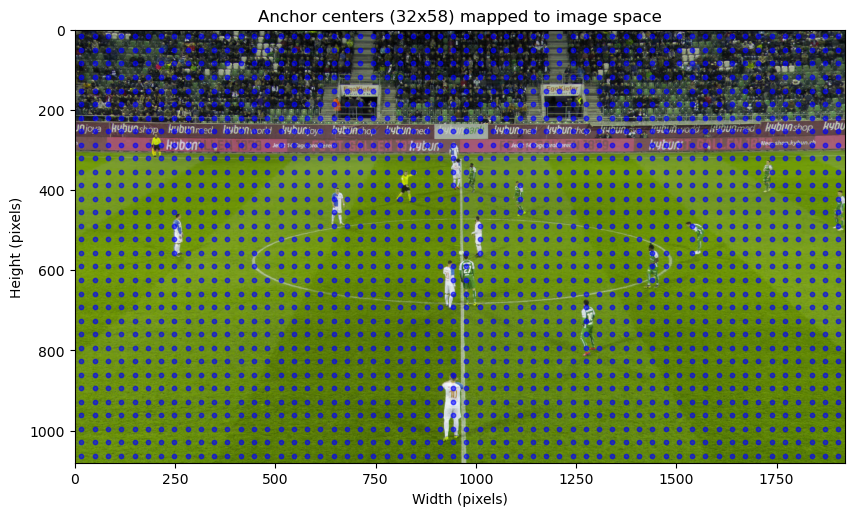

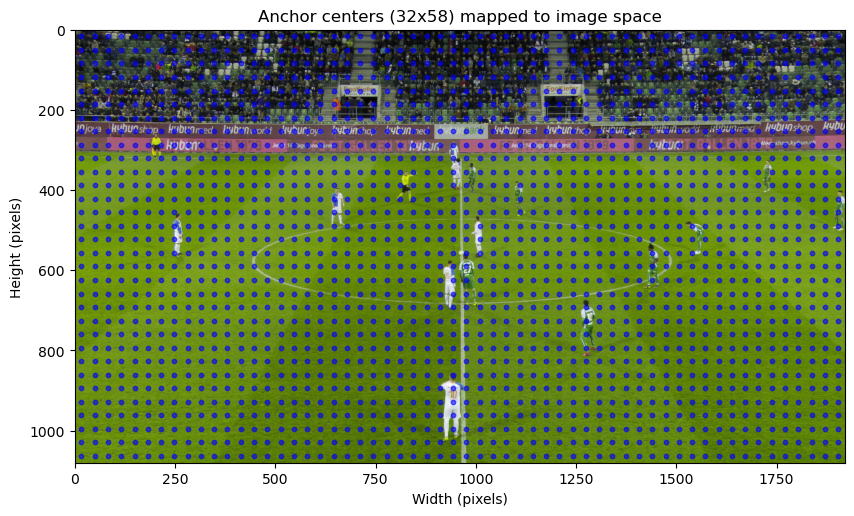

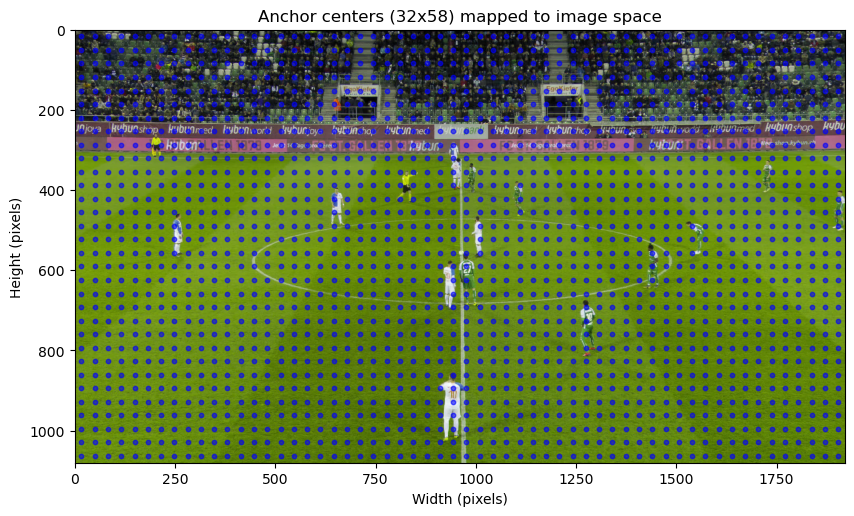

In [7]:

def visualize_anchors_on_sample_images(feature_extractor, image_dir='../soccernet_data/tracking/train/SNMOT-060/img1'):
    if not os.path.exists(image_dir):
        print(f"Directory {image_dir} does not exist.")
        return
    
    image_files = sorted(glob.glob(os.path.join(image_dir, '*.jpg')))
    sample_images = image_files[:3]
    
    image_net_mean = [0.485, 0.456, 0.406]
    image_net_std = [0.229, 0.224, 0.225]
    
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=image_net_mean, std=image_net_std)
    ])
    
    for img_path in sample_images:
        img = Image.open(img_path).convert('RGB')
        img_w, img_h = img.size
        img_tensor = transform(img).unsqueeze(0)
        
        feature_extractor.eval()
        with torch.no_grad():
            features = feature_extractor(img_tensor)
        
        feature_map_height = features.shape[2]
        feature_map_width = features.shape[3]
        
        downsampling_factor_h = img_h / feature_map_height
        downsampling_factor_w = img_w / feature_map_width
        
        scales = [8, 16, 32]
        aspect_ratios = [0.5, 1.0, 2.0]
        base_anchors = generate_base_anchors(scales, aspect_ratios, downsampling_factor_h, downsampling_factor_w)
        anchors = generate_anchor_boxes(
            (feature_map_height, feature_map_width),
            base_anchors,
            downsampling_factor_h,
            downsampling_factor_w
        )
        
        plt.figure(figsize=(10, 5.625))
        ax = plt.gca()
        ax.imshow(np.array(img), extent=(0, img_w, img_h, 0))
        
        center_y = np.arange(0, feature_map_height) * downsampling_factor_h + downsampling_factor_h / 2.0
        center_x = np.arange(0, feature_map_width) * downsampling_factor_w + downsampling_factor_w / 2.0
        center_x, center_y = np.meshgrid(center_x, center_y)
        
        ax.scatter(center_x, center_y, c='b', s=10, alpha=0.6, marker='o')
        ax.set_title(f'Anchor centers ({feature_map_height}x{feature_map_width}) mapped to image space')
        ax.set_xlim(0, img_w)
        ax.set_ylim(img_h, 0)
        ax.set_xlabel("Width (pixels)")
        ax.set_ylabel("Height (pixels)")
        ax.set_aspect('equal', adjustable='box')
        
        plt.show()
        
    

visualize_anchors_on_sample_images(feature_extractor)

# Experiment 4

In [8]:
from torch import ops


def get_iou_mat(batch_size, anc_boxes_all, gt_bboxes_all):
    """
    Computes the IoU matrix which contains IoU of every anchor box with all the ground truth boxes in the image. 
    It takes anchor boxes of shape: (B, w_amap, h_amap, n_anc_boxes, 4) 
    
    And ground truth boxes of shape (B, max_objects, 4) as the input 
    
    and returns a matrix of shape (B, anc_boxes_tot, max_objects) where the notations are as follows:

        B - Batch Size
        w_amap - width of the output activation map
        h_wmap - height of the output activation map
        n_anc_boxes - number of anchor boxes per an anchor point
        max_objects - max number of objects in a batch of images
        anc_boxes_tot - total number of anchor boxes in the image i.e, w_amap * h_amap * n_anc_boxes
    """
    
    anc_boxes_flat = anc_boxes_all.reshape(batch_size, -1, 4)
    tot_anc_boxes = anc_boxes_flat.size(dim=1)
    ious_mat = torch.zeros((batch_size, tot_anc_boxes, gt_bboxes_all.size(dim=1)))

    for i in range(batch_size):
        gt_bboxes = gt_bboxes_all[i]
        anc_boxes = anc_boxes_flat[i]
        ious_mat[i, :] = ops.box_iou(anc_boxes, gt_bboxes)
        
    return ious_mat

def project_bboxes(bboxes, width_scale_factor, height_scale_factor, mode='a2p'):
    """
    It's important to remember that the IoU is computed in the feature space between the generated anchor boxes and the projected ground truth boxes. 
    To project a ground truth box onto the feature space, we simply divide its coordinates by the scale factor as shown in the below function:
    """
    assert mode in ['a2p', 'p2a']
    
    batch_size = bboxes.size(dim=0)
    proj_bboxes = bboxes.clone().reshape(batch_size, -1, 4)
    invalid_bbox_mask = (proj_bboxes == -1) # indicating padded bboxes
    
    if mode == 'a2p':
        # activation map to pixel image
        proj_bboxes[:, :, [0, 2]] *= width_scale_factor
        proj_bboxes[:, :, [1, 3]] *= height_scale_factor
    else:
        # pixel image to activation map
        proj_bboxes[:, :, [0, 2]] /= width_scale_factor
        proj_bboxes[:, :, [1, 3]] /= height_scale_factor
        
    proj_bboxes.masked_fill_(invalid_bbox_mask, -1) # fill padded bboxes back with -1
    proj_bboxes.resize_as_(bboxes)
    
    return proj_bboxes



def calc_gt_offsets(pos_anc_coords, gt_bbox_mapping):

    """
    The postive anchor boxes do not exactly align with the ground truth boxes. So we compute offsets between the positive anchor boxes and the ground truth boxes and train a neural network to learn these offsets. The offsets can be computed as follows:

        tx_ = (gt_cx - anc_cx) / anc_w
        ty_ = (gt_cy - anc_cy) / anc_h
        tw_ = log(gt_w / anc_w)
        th_ = log(gt_h / anc_h)Where:gt_cx, gt_cy - centers of ground truth boxes
        anc_cx, anc_cy - centers of anchor boxes
        gt_w, gt_h - width and height of ground truth boxes
        anc_w, anc_h - width and height of anchor boxes
    """

    pos_anc_coords = ops.box_convert(pos_anc_coords, in_fmt='xyxy', out_fmt='cxcywh')
    gt_bbox_mapping = ops.box_convert(gt_bbox_mapping, in_fmt='xyxy', out_fmt='cxcywh')

    gt_cx, gt_cy, gt_w, gt_h = gt_bbox_mapping[:, 0], gt_bbox_mapping[:, 1], gt_bbox_mapping[:, 2], gt_bbox_mapping[:, 3]
    anc_cx, anc_cy, anc_w, anc_h = pos_anc_coords[:, 0], pos_anc_coords[:, 1], pos_anc_coords[:, 2], pos_anc_coords[:, 3]

    tx_ = (gt_cx - anc_cx)/anc_w
    ty_ = (gt_cy - anc_cy)/anc_h
    tw_ = torch.log(gt_w / anc_w)
    th_ = torch.log(gt_h / anc_h)

    return torch.stack([tx_, ty_, tw_, th_], dim=-1)


def get_req_anchors(anc_boxes_all, gt_bboxes_all, gt_classes_all, pos_thresh=0.7, neg_thresh=0.2):
    '''
    Prepare necessary data required for training
    
    Input
    ------
    anc_boxes_all - torch.Tensor of shape (B, w_amap, h_amap, n_anchor_boxes, 4)
        all anchor boxes for a batch of images
    gt_bboxes_all - torch.Tensor of shape (B, max_objects, 4)
        padded ground truth boxes for a batch of images
    gt_classes_all - torch.Tensor of shape (B, max_objects)
        padded ground truth classes for a batch of images
        
    Returns
    ---------
    positive_anc_ind -  torch.Tensor of shape (n_pos,)
        flattened positive indices for all the images in the batch
    negative_anc_ind - torch.Tensor of shape (n_pos,)
        flattened positive indices for all the images in the batch
    GT_conf_scores - torch.Tensor of shape (n_pos,), IoU scores of +ve anchors
    GT_offsets -  torch.Tensor of shape (n_pos, 4),
        offsets between +ve anchors and their corresponding ground truth boxes
    GT_class_pos - torch.Tensor of shape (n_pos,)
        mapped classes of +ve anchors
    positive_anc_coords - (n_pos, 4) coords of +ve anchors (for visualization)
    negative_anc_coords - (n_pos, 4) coords of -ve anchors (for visualization)
    positive_anc_ind_sep - list of indices to keep track of +ve anchors
    '''
    # get the size and shape parameters
    B, w_amap, h_amap, A, _ = anc_boxes_all.shape
    N = gt_bboxes_all.shape[1] # max number of groundtruth bboxes in a batch
    
    # get total number of anchor boxes in a single image
    tot_anc_boxes = A * w_amap * h_amap
    
    # get the iou matrix which contains iou of every anchor box
    # against all the groundtruth bboxes in an image
    iou_mat = get_iou_mat(B, anc_boxes_all, gt_bboxes_all)
    
    # for every groundtruth bbox in an image, find the iou 
    # with the anchor box which it overlaps the most
    max_iou_per_gt_box, _ = iou_mat.max(dim=1, keepdim=True)
    
    # get positive anchor boxes
    
    # condition 1: the anchor box with the max iou for every gt bbox
    positive_anc_mask = torch.logical_and(iou_mat == max_iou_per_gt_box, max_iou_per_gt_box > 0) 
    # condition 2: anchor boxes with iou above a threshold with any of the gt bboxes
    positive_anc_mask = torch.logical_or(positive_anc_mask, iou_mat > pos_thresh)
    
    positive_anc_ind_sep = torch.where(positive_anc_mask)[0] # get separate indices in the batch
    # combine all the batches and get the idxs of the +ve anchor boxes
    positive_anc_mask = positive_anc_mask.flatten(start_dim=0, end_dim=1)
    positive_anc_ind = torch.where(positive_anc_mask)[0]
    
    # for every anchor box, get the iou and the idx of the
    # gt bbox it overlaps with the most
    max_iou_per_anc, max_iou_per_anc_ind = iou_mat.max(dim=-1)
    max_iou_per_anc = max_iou_per_anc.flatten(start_dim=0, end_dim=1)
    
    # get iou scores of the +ve anchor boxes
    GT_conf_scores = max_iou_per_anc[positive_anc_ind]
    
    # get gt classes of the +ve anchor boxes
    
    # expand gt classes to map against every anchor box
    gt_classes_expand = gt_classes_all.view(B, 1, N).expand(B, tot_anc_boxes, N)
    # for every anchor box, consider only the class of the gt bbox it overlaps with the most
    GT_class = torch.gather(gt_classes_expand, -1, max_iou_per_anc_ind.unsqueeze(-1)).squeeze(-1)
    # combine all the batches and get the mapped classes of the +ve anchor boxes
    GT_class = GT_class.flatten(start_dim=0, end_dim=1)
    GT_class_pos = GT_class[positive_anc_ind]
    
    # get gt bbox coordinates of the +ve anchor boxes
    
    # expand all the gt bboxes to map against every anchor box
    gt_bboxes_expand = gt_bboxes_all.view(B, 1, N, 4).expand(B, tot_anc_boxes, N, 4)
    # for every anchor box, consider only the coordinates of the gt bbox it overlaps with the most
    GT_bboxes = torch.gather(gt_bboxes_expand, -2, max_iou_per_anc_ind.reshape(B, tot_anc_boxes, 1, 1).repeat(1, 1, 1, 4))
    # combine all the batches and get the mapped gt bbox coordinates of the +ve anchor boxes
    GT_bboxes = GT_bboxes.flatten(start_dim=0, end_dim=2)
    GT_bboxes_pos = GT_bboxes[positive_anc_ind]
    
    # get coordinates of +ve anc boxes
    anc_boxes_flat = anc_boxes_all.flatten(start_dim=0, end_dim=-2) # flatten all the anchor boxes
    positive_anc_coords = anc_boxes_flat[positive_anc_ind]
    
    # calculate gt offsets
    GT_offsets = calc_gt_offsets(positive_anc_coords, GT_bboxes_pos)
    
    # get -ve anchors
    
    # condition: select the anchor boxes with max iou less than the threshold
    negative_anc_mask = (max_iou_per_anc < neg_thresh)
    negative_anc_ind = torch.where(negative_anc_mask)[0]
    # sample -ve samples to match the +ve samples
    negative_anc_ind = negative_anc_ind[torch.randint(0, negative_anc_ind.shape[0], (positive_anc_ind.shape[0],))]
    negative_anc_coords = anc_boxes_flat[negative_anc_ind]
    
    return positive_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class_pos, \
         positive_anc_coords, negative_anc_coords, positive_anc_ind_sep

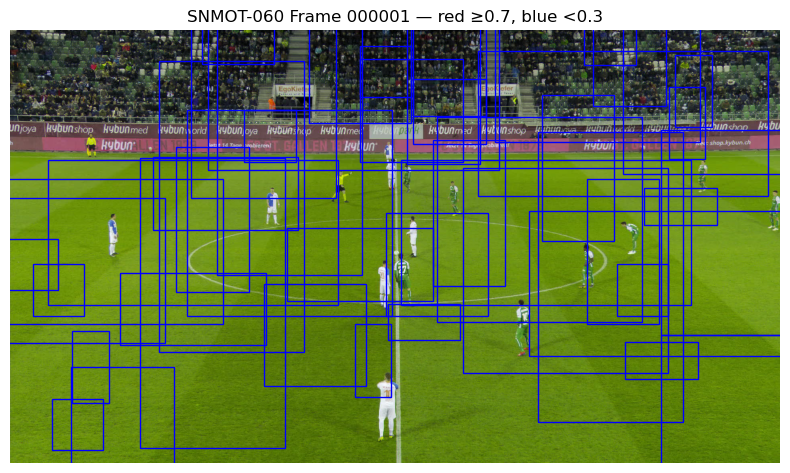

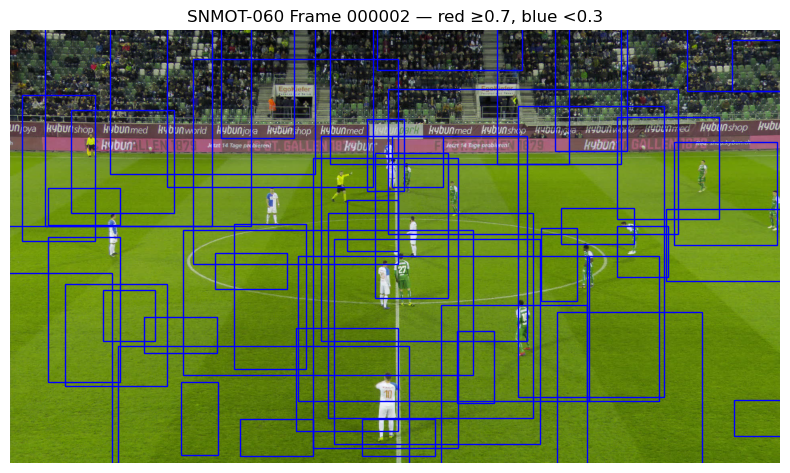

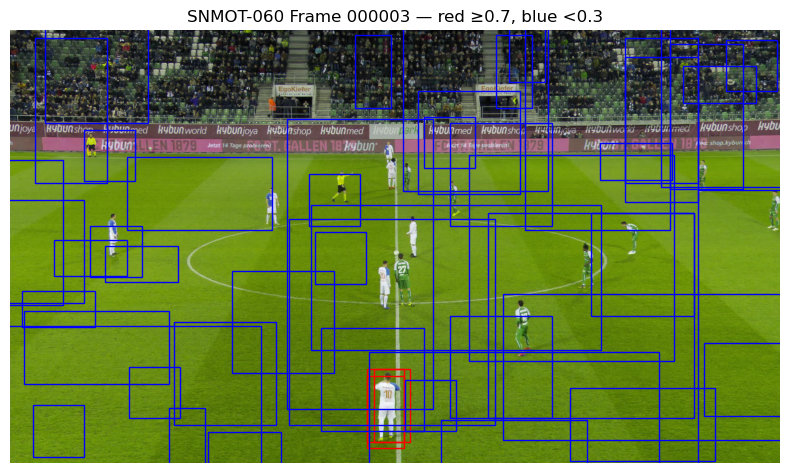

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# --- (from Exp2) anchor‐generation routines ---

def generate_base_anchors(scales, aspect_ratios, down_h, down_w):
    ctr_y, ctr_x = down_h/2.0, down_w/2.0
    A = len(scales) * len(aspect_ratios)
    base = np.zeros((A,4), dtype=np.float32)
    idx = 0
    for s in scales:
        for ar in aspect_ratios:
            h = down_h * s * np.sqrt(ar)
            w = down_w * s * np.sqrt(1/ar)
            base[idx,0] = ctr_y - h/2.0  # y_min
            base[idx,1] = ctr_x - w/2.0  # x_min
            base[idx,2] = ctr_y + h/2.0  # y_max
            base[idx,3] = ctr_x + w/2.0  # x_max
            idx += 1
    return base

def generate_anchor_boxes(fmap_size, base_anchors, down_h, down_w):
    Hf, Wf = fmap_size
    shift_y = np.arange(0, Hf) * down_h
    shift_x = np.arange(0, Wf) * down_w
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    shifts = np.stack([shift_y.ravel(), shift_x.ravel(),
                       shift_y.ravel(), shift_x.ravel()], axis=1)
    K = shifts.shape[0]; A = base_anchors.shape[0]
    all_ = base_anchors.reshape((1,A,4)) + shifts.reshape((K,1,4))
    return all_.reshape((K*A,4))

def compute_iou(boxes1, boxes2):
    # boxes: [ymin, xmin, ymax, xmax]
    N, M = boxes1.shape[0], boxes2.shape[0]
    y1 = np.maximum(boxes1[:,None,0], boxes2[None,:,0])
    x1 = np.maximum(boxes1[:,None,1], boxes2[None,:,1])
    y2 = np.minimum(boxes1[:,None,2], boxes2[None,:,2])
    x2 = np.minimum(boxes1[:,None,3], boxes2[None,:,3])
    h = np.clip(y2 - y1, 0, None)
    w = np.clip(x2 - x1, 0, None)
    inter = h * w
    area1 = (boxes1[:,2]-boxes1[:,0])*(boxes1[:,3]-boxes1[:,1])
    area2 = (boxes2[:,2]-boxes2[:,0])*(boxes2[:,3]-boxes2[:,1])
    union = area1[:,None] + area2[None,:] - inter
    return inter / union

# --- parameters ---
sequence_id       = "SNMOT-060"
frame_ids         = [1,2,3]
pos_thresh        = 0.7
neg_thresh        = 0.3
scales            = [8,16,32]
aspect_ratios     = [0.5,1.0,2.0]
down_h = down_w  = 16   # assume backbone stride=16

for fid in frame_ids:
    # load image
    img_path = os.path.join("..", "soccernet_data","tracking","train",
                             sequence_id,"img1",f"{fid:06d}.jpg")
    img = np.array(Image.open(img_path))
    H, W = img.shape[:2]

    # make anchors over this image
    fmap_h, fmap_w = H // down_h, W // down_w
    base_anchors   = generate_base_anchors(scales, aspect_ratios, down_h, down_w)
    all_anchors    = generate_anchor_boxes((fmap_h,fmap_w),
                                           base_anchors, down_h, down_w)

    # load per‐frame GT
    gt_path = os.path.join("..", "soccernet_data","tracking","train",
                            sequence_id,"gt-frame",f"{fid:06d}.txt")
    raw = np.loadtxt(gt_path, delimiter=",")
    raw = raw.reshape(-1,5)      # in case only one box
    gt_boxes = raw[:,1:]         # drop track_id

    # compute IoU
    ious = compute_iou(all_anchors, gt_boxes)
    max_iou = ious.max(axis=1)
    pos_idx = np.where(max_iou >= pos_thresh)[0]
    neg_idx = np.where(max_iou <  neg_thresh)[0]

    # sample up to 50 of each for clarity
    if len(pos_idx)>50:
        pos_idx = np.random.choice(pos_idx, 50, replace=False)
    if len(neg_idx)>50:
        neg_idx = np.random.choice(neg_idx, 50, replace=False)

    # plot
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(img)
    # positives in red
    for i in pos_idx:
        y1,x1,y2,x2 = all_anchors[i]
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1,
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    # negatives in blue
    for i in neg_idx:
        y1,x1,y2,x2 = all_anchors[i]
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1,
                                 linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)

    ax.set_title(f"{sequence_id} Frame {fid:06d} — red ≥{pos_thresh}, blue <{neg_thresh}")
    ax.axis('off')
    plt.tight_layout()
    plt.show()


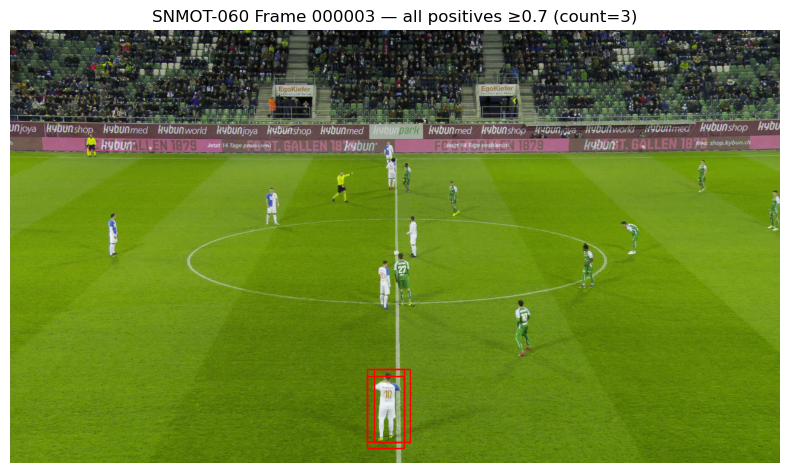

In [10]:
# recompute all positive anchors (no sampling)
pos_idx_all = np.where(max_iou >= pos_thresh)[0]

# plot all positive anchors in red
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(img)
for i in pos_idx_all:
    y1, x1, y2, x2 = all_anchors[i]
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                             linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.set_title(f"{sequence_id} Frame {fid:06d} — all positives ≥{pos_thresh} (count={len(pos_idx_all)})")
ax.axis('off')
plt.tight_layout()
plt.show()
